#1-1

MNIST 데이터셋을 사용하여 간단한 VAE을 구현한 코드입니다.

코드를 실행시키고, 주석을 달아주세요.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
num_epochs = 50
batch_size = 100
learning_rate = 0.0002
img_size = 28 * 28
latent_dim = 20
hidden_size1 = 256
hidden_size2 = 512
hidden_size3 = 1024
dir_name = "VAE_results"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if not os.path.exists(dir_name):
    os.makedirs(dir_name)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
MNIST_dataset = datasets.MNIST(root='../../data/',
                               train=True,
                               transform=transform,
                               download=True)

data_loader = torch.utils.data.DataLoader(dataset=MNIST_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 47860900.41it/s]


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1928451.70it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 14398508.07it/s]


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3753798.77it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



In [4]:
class Encoder(nn.Module):  #인코더 클래스 정의
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(img_size, hidden_size3)
        self.fc2 = nn.Linear(hidden_size3, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size1)
        #잠재 공간의 평균과 분산을 추출하기 위한 선형레이어
        self.fc_mean = nn.Linear(hidden_size1, latent_dim)
        self.fc_logvar = nn.Linear(hidden_size1, latent_dim)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x):
      #인코딩 과정 (이미지를 잠재 벡터로 압축)
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

#디코더 클래스 정의
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        #잠재 벡터를 이미지 크기로 복원
        self.fc1 = nn.Linear(latent_dim, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, img_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

encoder = Encoder().to(device)
decoder = Decoder().to(device)

In [5]:
#Reparameterization Trick
# VAE에서는 잠재 변수에서 샘플링해야 하지만, 역전파 계산이 어려움
#이 문제를 해결하기 위해 평균과 로그 분산에서 샘플링하는 대신, 랜덤 노이즈를 추가하는 방법으로 샘플링 과정을 분리함

def reparameterize(mean, logvar):
    std = torch.exp(0.5 * logvar)
    #표준 정규분포로부터 랜덤 노이즈 샘플링
    eps = torch.randn_like(std)
    #샘플링된 잠재 벡터 변환
    return mean + eps * std

#Reconstruction Loss + KL Divergence로 구성
def loss_function(recon_x, x, mean, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

In [6]:
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    train_loss = 0

    for images, _ in data_loader:
        images = images.view(-1, img_size).to(device)

        images = (images + 1) / 2

        optimizer.zero_grad()

        mean, logvar = encoder(images)
        z = reparameterize(mean, logvar)
        recon_images = decoder(z)

        loss = loss_function(recon_images, images, mean, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(data_loader.dataset)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

    with torch.no_grad():
        z = torch.randn(batch_size, latent_dim).to(device)
        sample = decoder(z).view(-1, 1, 28, 28)
        save_image(sample, os.path.join(dir_name, f'VAE_fake_image_{epoch + 1}.png'))

Epoch [1/50], Loss: 200.2400
Epoch [2/50], Loss: 149.2230
Epoch [3/50], Loss: 130.7556
Epoch [4/50], Loss: 123.3392
Epoch [5/50], Loss: 119.3918
Epoch [6/50], Loss: 116.2143
Epoch [7/50], Loss: 113.7889
Epoch [8/50], Loss: 112.0150
Epoch [9/50], Loss: 110.5233
Epoch [10/50], Loss: 109.1028
Epoch [11/50], Loss: 107.7596
Epoch [12/50], Loss: 106.6218
Epoch [13/50], Loss: 105.8017
Epoch [14/50], Loss: 105.0474
Epoch [15/50], Loss: 104.4102
Epoch [16/50], Loss: 103.8230
Epoch [17/50], Loss: 103.3122
Epoch [18/50], Loss: 102.8752
Epoch [19/50], Loss: 102.4699
Epoch [20/50], Loss: 102.0139
Epoch [21/50], Loss: 101.6484
Epoch [22/50], Loss: 101.3190
Epoch [23/50], Loss: 101.0250
Epoch [24/50], Loss: 100.7201
Epoch [25/50], Loss: 100.3909
Epoch [26/50], Loss: 100.1196
Epoch [27/50], Loss: 99.8840
Epoch [28/50], Loss: 99.6503
Epoch [29/50], Loss: 99.4107
Epoch [30/50], Loss: 99.1582
Epoch [31/50], Loss: 98.9836
Epoch [32/50], Loss: 98.7527
Epoch [33/50], Loss: 98.5630
Epoch [34/50], Loss: 98.37

#1-2

아래 마크다운으로 VAE_fake_image_1.png와 VAE_fake_image_50.png를 함께 첨부해주세요.

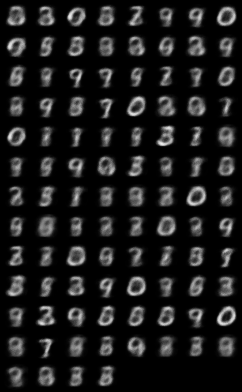

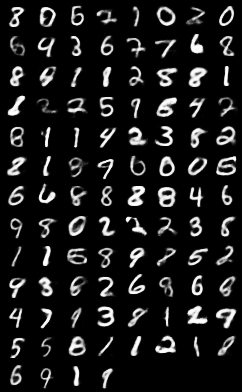